In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [22]:
filings_metadata = pd.read_csv(r'C:\Users\P70088982\Documents\edgar-crawler\datasets\filings_metadata.csv')
filings_metadata['SIC'] = filings_metadata['SIC'].fillna(0).astype(int)

# Companies over time

In [23]:
filings_metadata['Period of Report'] = pd.to_datetime(filings_metadata['Period of Report'], format='%Y-%m-%d')
filings_metadata['Filing Date'] = pd.to_datetime(filings_metadata['Filing Date'], format='%Y-%m-%d')
filings_metadata['reporting_year'] = filings_metadata['Period of Report'].dt.year


In [24]:
filings_metadata.groupby('reporting_year')['CIK'].agg(['count', 'nunique']).reset_index().tail(7)

,reporting_year,count,nunique
19,2019,5577,5515
20,2020,7023,6949
21,2021,7757,7663
22,2022,7482,7346
23,2023,6937,6834
24,2024,6218,6123
25,2025,91,91


Only include the filings relevant to the years [2020,2024]

In [25]:
filings_metadata = filings_metadata[filings_metadata.reporting_year.isin(range(2020,2025))]

In [26]:
companies_per_year = filings_metadata.groupby('reporting_year')[['CIK']].nunique()
companies_per_year.columns = ['companies']

# Company sampling

In [5]:
ai_mentions = pd.read_csv(r'C:\Users\P70088982\Documents\edgar-crawler\datasets\ai_mentions.csv')
ai_mentions = ai_mentions[ai_mentions.reporting_year.isin(range(2020,2025))]

In [19]:
random_50 = ai_mentions.groupby('company')[['cik']].first().sample(50, random_state=42)

In [20]:
random_50.to_excel('../datasets/random_50.xlsx')

# 1 vs 1A items over time

In [27]:
ai_mentions = pd.read_csv(r'C:\Users\P70088982\Documents\edgar-crawler\datasets\ai_mentions.csv')
ai_mentions = ai_mentions[ai_mentions.reporting_year.isin(range(2020,2025))]

In [28]:
companies_ai_mentioned_norm = ai_mentions.groupby('reporting_year')[['cik']].nunique().rename(columns={'cik': 'companies'})/ companies_per_year
companies_ai_mentioned_norm.columns = ['companies_per']

Time taken to file

In [29]:
filings_metadata['submission_length'] = (filings_metadata['Filing Date'] - filings_metadata['Period of Report']).dt.days

In [30]:
filings_metadata.submission_length.describe(percentiles=[0.9, 0.99])

count    35417.000000
mean        75.314934
std         39.478440
min          0.000000
50%         72.000000
90%         92.000000
99%        212.840000
max       1380.000000
Name: submission_length, dtype: float64

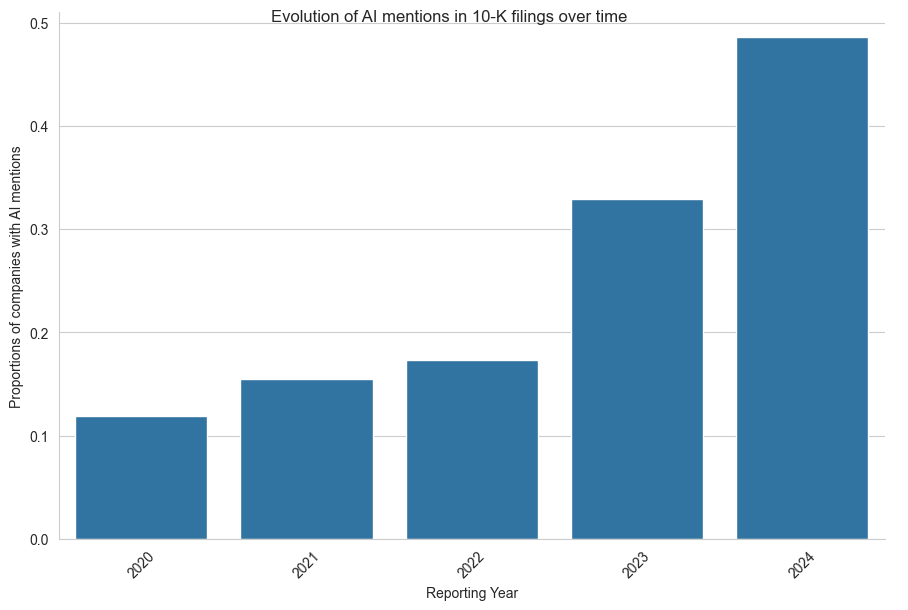

In [31]:
# Seaborn scatter plot of evolution in number of mentions over time (split by match field)
import seaborn as sns
import matplotlib.pyplot as plt

with sns.axes_style(style="whitegrid"):
    # Increase dot size
    g = sns.catplot(data=companies_ai_mentioned_norm.reset_index(), x='reporting_year', y='companies_per', kind='bar', height=6, legend_out=True, aspect=1.5)
    g.fig.suptitle('Evolution of AI mentions in 10-K filings over time')

    g.set_xticklabels(rotation=45)
    g.set_xlabels('Reporting Year')
    g.set_ylabels('Proportions of companies with AI mentions')
    plt.savefig('../figures/proportion_ai_mentions.jpg', dpi=300, bbox_inches='tight')
    plt.show()


In [32]:
ai_mentions.groupby(['reporting_year', 'match_field', 'cik']).nunique()[['sentence']].reset_index().groupby(['reporting_year', 'match_field']).sum()[['cik']]

cik
reporting_year match_field            
2020           1A_matches    246816131
               1_matches     922199224
               3_matches       2830134
               7_matches     284208046
2021           1A_matches    407911095
               1_matches    1485266807
               3_matches       3872180
               7_matches     429503355
2022           1A_matches    528594663
               1_matches    1496439674
               3_matches       4283478
               7_matches     456941540
2023           1A_matches   2030979699
               1_matches    1640169792
               3_matches       5083113
               7_matches     556326562
2024           1A_matches   3126453173
               1_matches    1702379537
               3_matches       6464310
               7_matches     679446370

C:\Users\P70088982\AppData\Local\Temp\ipykernel_25552\2557809916.py:5: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  companies_per_item = grouped.set_index('reporting_year').join(companies_per_year, on='reporting_year')


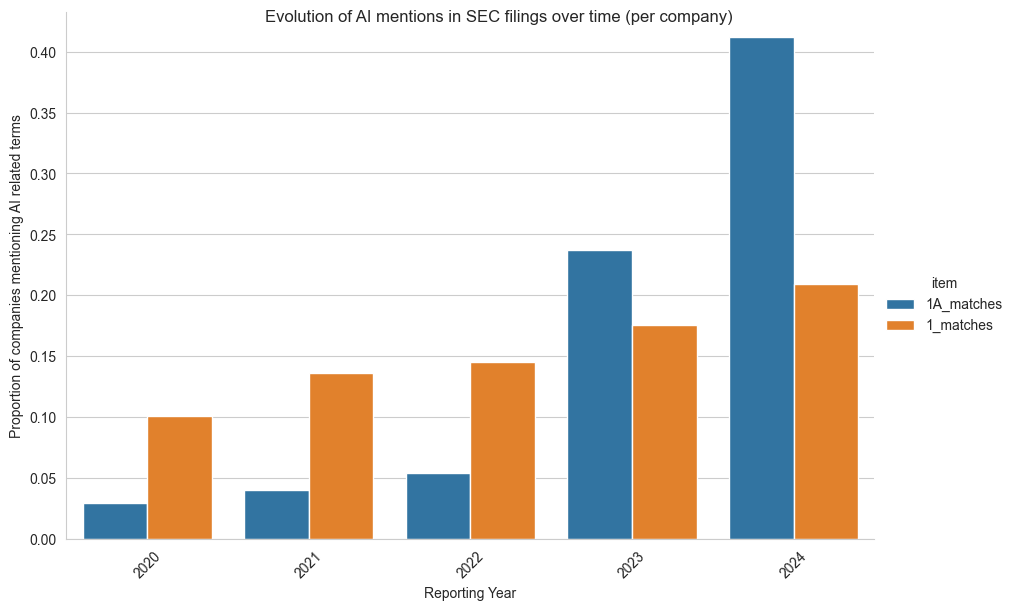

In [34]:
# Seaborn scatter plot of evolution in number of mentions over time (split by match field)
import seaborn as sns
import matplotlib.pyplot as plt
grouped = ai_mentions[ai_mentions.match_field.isin(['1_matches', '1A_matches'])].groupby(['reporting_year', 'match_field']).agg(['nunique'])[['cik']].reset_index()
companies_per_item = grouped.set_index('reporting_year').join(companies_per_year, on='reporting_year')
companies_per_item.columns = ['item', 'companies', 'total_companies']
companies_per_item['companies_proportion'] = companies_per_item['companies'] / companies_per_item['total_companies']

with sns.axes_style(style="whitegrid"):
    # Increase dot size
    g = sns.catplot(data=companies_per_item, x='reporting_year', y='companies_proportion', hue='item', kind='bar', height=6, legend_out=True, aspect=1.5)
    g.fig.suptitle('Evolution of AI mentions in SEC filings over time (per company)')

    g.set_xticklabels(rotation=45)
    g.set_xlabels('Reporting Year')
    g.set_ylabels('Proportion of companies mentioning AI related terms')
    plt.savefig('../figures/proportion_ai_mentions_per_item.jpg', dpi=300, bbox_inches='tight')
    plt.show()



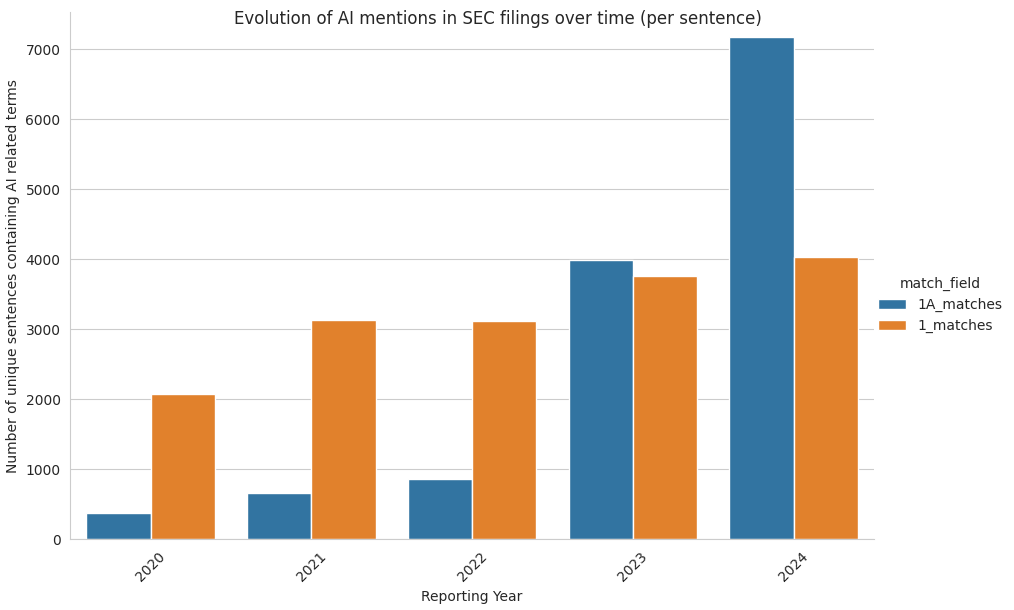

In [35]:
# Seaborn scatter plot of evolution in number of mentions over time (split by match field)
import seaborn as sns
import matplotlib.pyplot as plt
grouped = ai_mentions[ai_mentions.match_field.isin(['1_matches', '1A_matches'])].groupby(['reporting_year', 'match_field']).agg(['nunique'])[['sentence']].reset_index()

with sns.axes_style(style="whitegrid"):
    # Increase dot size
    g = sns.catplot(data=grouped, x='reporting_year', y=('sentence', 'nunique'), hue='match_field', kind='bar', height=6, legend_out=True, aspect=1.5)
    g.fig.suptitle('Evolution of AI mentions in SEC filings over time (per sentence)')

    g.set_xticklabels(rotation=45)
    g.set_xlabels('Reporting Year')
    g.set_ylabels('Number of unique sentences containing AI related terms')



# Item 1 and 1A company overlap

In [58]:
# Pivot on the match_field
mention_types = ai_mentions.groupby(['reporting_year', 'match_field', 'cik']).nunique()[['sentence']].reset_index().pivot(index=['reporting_year', 'cik'], columns='match_field', values='sentence').fillna(0).reset_index()

In [60]:
mention_types['only_1_matches'] = mention_types['1_matches'] != 0 & mention_types['1A_matches'] == 0 & mention_types['3_matches'] == 0 & mention_types['7_matches'] == 0 

TypeError: Cannot perform 'rand_' with a dtyped [float64] array and scalar of type [bool]

# Industry level

In [ ]:
sic_codes = pd.read_csv(r'C:\Users\P70088982\Documents\edgar-crawler\datasets\sic_codes.csv').set_index('SIC Code')

In [ ]:
ai_mentions.cik = ai_mentions.cik.astype(int)

In [ ]:
df = ai_mentions.set_index('cik').join(filings_metadata.groupby(['CIK'])['SIC'].max(), how='left').reset_index().rename(columns={'index': 'cik'})
df = df.set_index('SIC').join(sic_codes, how='left').reset_index().rename(columns={'index': 'sic'})

In [ ]:
grouped = df[df.match_field.isin(['1_matches', '1A_matches'])].groupby(['filing_year', 'match_field', 'sic', 'Industry Title']).agg(['count', 'nunique'])[['cik']].reset_index()

In [ ]:
top_5 = grouped[grouped.sic.isin(grouped[grouped.filing_year==2025].sort_values(by=[('cik', 'nunique')], ascending=False).head(5).sic)]

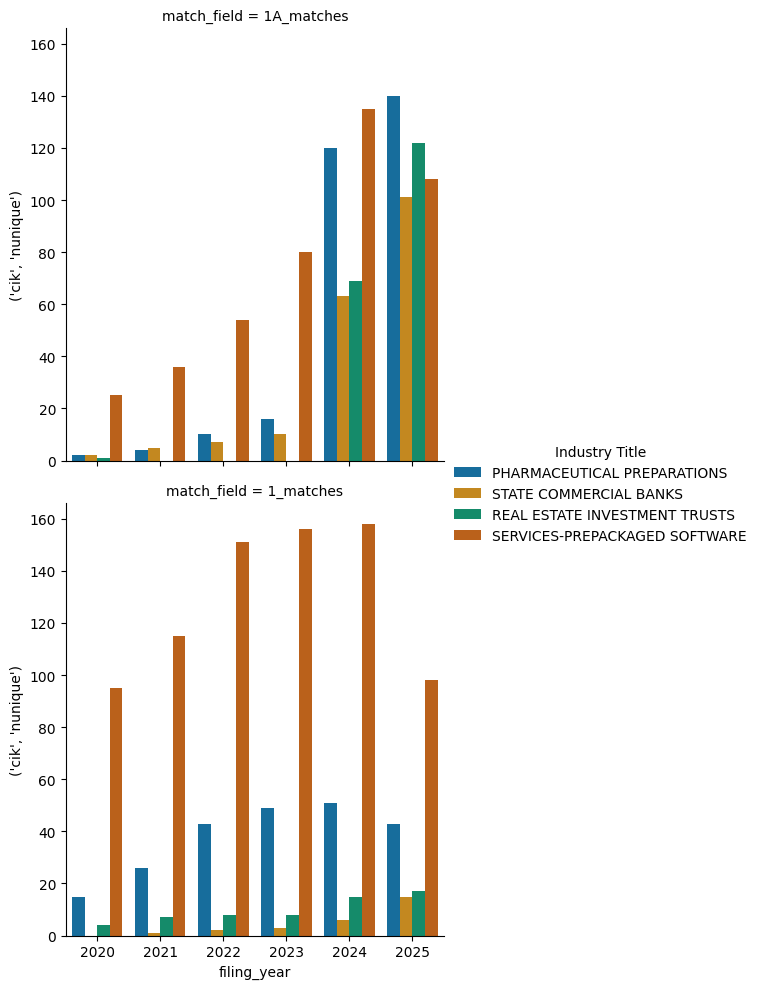

In [ ]:
sns.catplot(data=top_5, x='filing_year', y=('cik', 'nunique'), hue='Industry Title', row='match_field', kind='bar', palette='colorblind')